#  Flight Delay Forecasting — EUROCONTROL ANSP Dataset

**Goal:** Predict daily en-route flight delays using EUROCONTROL ANSP data (2020–2024).  
Accurate forecasting of delays helps airlines, airports, and air navigation service providers optimize resources, reduce congestion, and minimize passenger disruptions.

**Key steps in this notebook:**
- Load & clean historical delay data
- Aggregate daily delays
- Analyze patterns and trends
- Build & evaluate a forecasting model (SARIMA)
- Derive operational insights for decision-makers


 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import bz2
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


 Load and Merge All CSV Files

In [3]:

path = r"C:\Users\User\OneDrive\Desktop\datascientistProject\projects\flight delay"

files = sorted(glob(path + r"\ert_dly_ansp_*.csv.bz2"))
files


['C:\\Users\\User\\OneDrive\\Desktop\\datascientistProject\\projects\\flight delay\\ert_dly_ansp_2020.csv.bz2',
 'C:\\Users\\User\\OneDrive\\Desktop\\datascientistProject\\projects\\flight delay\\ert_dly_ansp_2021.csv.bz2',
 'C:\\Users\\User\\OneDrive\\Desktop\\datascientistProject\\projects\\flight delay\\ert_dly_ansp_2023.csv.bz2',
 'C:\\Users\\User\\OneDrive\\Desktop\\datascientistProject\\projects\\flight delay\\ert_dly_ansp_2024.csv.bz2']

In [4]:
# Read and concatenate all bz2 CSV files
df_list = []
for file in files:
    with bz2.open(file, 'rt') as f:
        temp_df = pd.read_csv(f)
        temp_df['year'] = file.split('_')[-1].split('.')[0]  # Extract year from filename
        df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
print("✅ Total rows:", len(df))
df.head()


✅ Total rows: 50628


,YEAR,MONTH_NUM,MONTH_MON,FLT_DATE,ENTITY_NAME,ENTITY_TYPE,FLT_ERT_1,DLY_ERT_1,DLY_ERT_A_1,DLY_ERT_C_1,...,DLY_ERT_P_1,DLY_ERT_R_1,DLY_ERT_S_1,DLY_ERT_T_1,DLY_ERT_V_1,DLY_ERT_W_1,DLY_ERT_NA_1,FLT_ERT_1_DLY,FLT_ERT_1_DLY_15,year
0,2020,1,JAN,2020-01-01T00:00:00Z,Albcontrol,ANSP (AUA),383,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
1,2020,1,JAN,2020-01-01T00:00:00Z,ANA LUX,ANSP (AUA),130,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
2,2020,1,JAN,2020-01-01T00:00:00Z,ANS CR,ANSP (AUA),1599,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
3,2020,1,JAN,2020-01-01T00:00:00Z,ANS Finland,ANSP (AUA),556,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
4,2020,1,JAN,2020-01-01T00:00:00Z,ARMATS,ANSP (AUA),186,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020


 Data Cleaning & Feature Engineering

In [6]:
# Checking column names
display(df.columns)

Index(['YEAR', 'MONTH_NUM', 'MONTH_MON', 'FLT_DATE', 'ENTITY_NAME',
       'ENTITY_TYPE', 'FLT_ERT_1', 'DLY_ERT_1', 'DLY_ERT_A_1', 'DLY_ERT_C_1',
       'DLY_ERT_D_1', 'DLY_ERT_E_1', 'DLY_ERT_G_1', 'DLY_ERT_I_1',
       'DLY_ERT_M_1', 'DLY_ERT_N_1', 'DLY_ERT_O_1', 'DLY_ERT_P_1',
       'DLY_ERT_R_1', 'DLY_ERT_S_1', 'DLY_ERT_T_1', 'DLY_ERT_V_1',
       'DLY_ERT_W_1', 'DLY_ERT_NA_1', 'FLT_ERT_1_DLY', 'FLT_ERT_1_DLY_15',
       'year'],
      dtype='object')

In [7]:
# Converting FLT_DATE to proper datetime
df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'], errors='coerce')

In [8]:
# Drop rows with missing dates
df = df.dropna(subset=['FLT_DATE'])

In [9]:
# Sort by date
df = df.sort_values(by='FLT_DATE')


In [10]:
# Checking for missing delay values in total delay column
print(df['FLT_ERT_1_DLY'].isna().sum())

36399


In [11]:
# Replace NaNs in delay column with 0
df['FLT_ERT_1_DLY'] = df['FLT_ERT_1_DLY'].fillna(0)

In [12]:
# Rename for clarity
df = df.rename(columns={'FLT_ERT_1_DLY': 'TOTAL_DELAY'})

Exploratory Data Analysis (EDA)

Aggregate Daily Total Delays
Since each date has multiple entities (e.g., different ANSPs), we sum them up per day:

In [13]:
daily_delays = df.groupby('FLT_DATE')['TOTAL_DELAY'].sum().reset_index()
daily_delays = daily_delays.rename(columns={'FLT_DATE': 'DATE'})
daily_delays = daily_delays.set_index('DATE')
daily_delays = daily_delays.asfreq('D').fillna(0)  # Fill missing days with 0 delay
daily_delays.head()


,TOTAL_DELAY
DATE,
2020-01-01 00:00:00+00:00,1011.0
2020-01-02 00:00:00+00:00,3254.0
2020-01-03 00:00:00+00:00,1954.0
2020-01-04 00:00:00+00:00,6049.0
2020-01-05 00:00:00+00:00,4186.0


we now have a clean daily time series of total delay minutes across all ANSP entities.
5: Visualize the Time Series

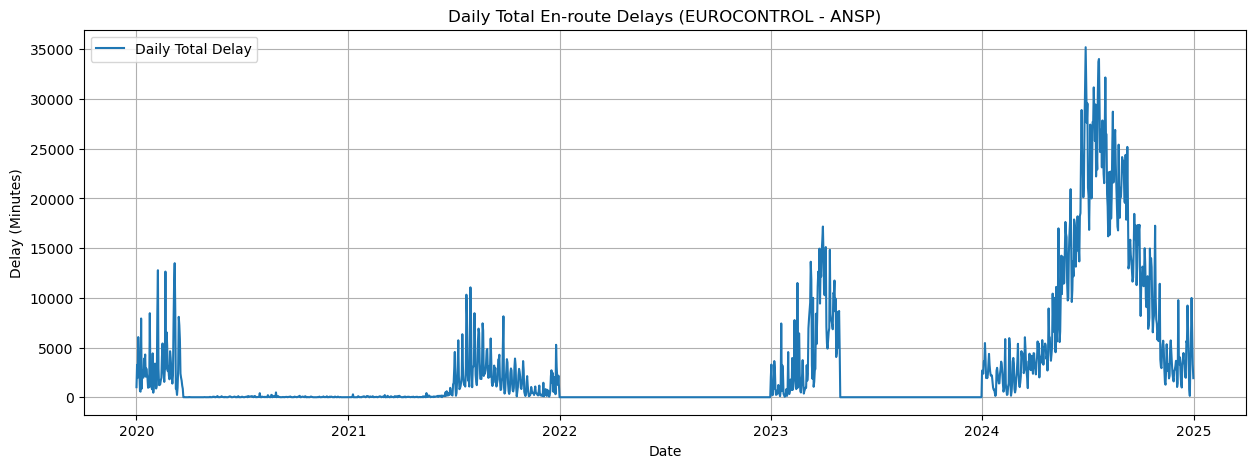

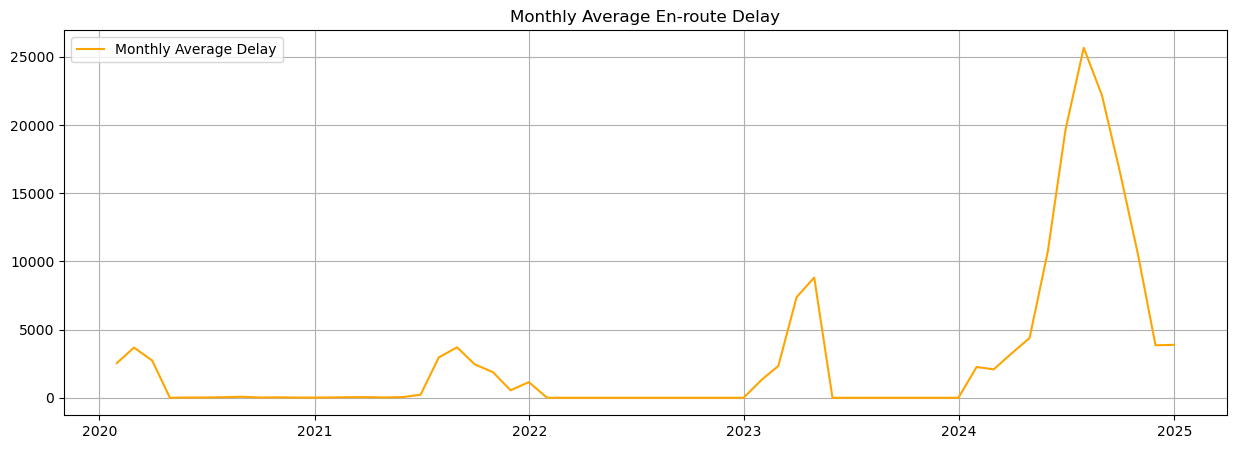

In [14]:
import matplotlib.pyplot as plt
# Daily trend plot
plt.figure(figsize=(15,5))
plt.plot(daily_delays.index, daily_delays['TOTAL_DELAY'], label='Daily Total Delay')
plt.title('Daily Total En-route Delays (EUROCONTROL - ANSP)')
plt.xlabel('Date')
plt.ylabel('Delay (Minutes)')
plt.grid(True)
plt.legend()
plt.show()

# monthly average
monthly = daily_delays.resample('M').mean()
plt.figure(figsize=(15,5))
plt.plot(monthly.index, monthly['TOTAL_DELAY'], color='orange', label='Monthly Average Delay')
plt.title('Monthly Average En-route Delay')
plt.grid(True)
plt.legend()
plt.show()


Top Entities Causing Delays

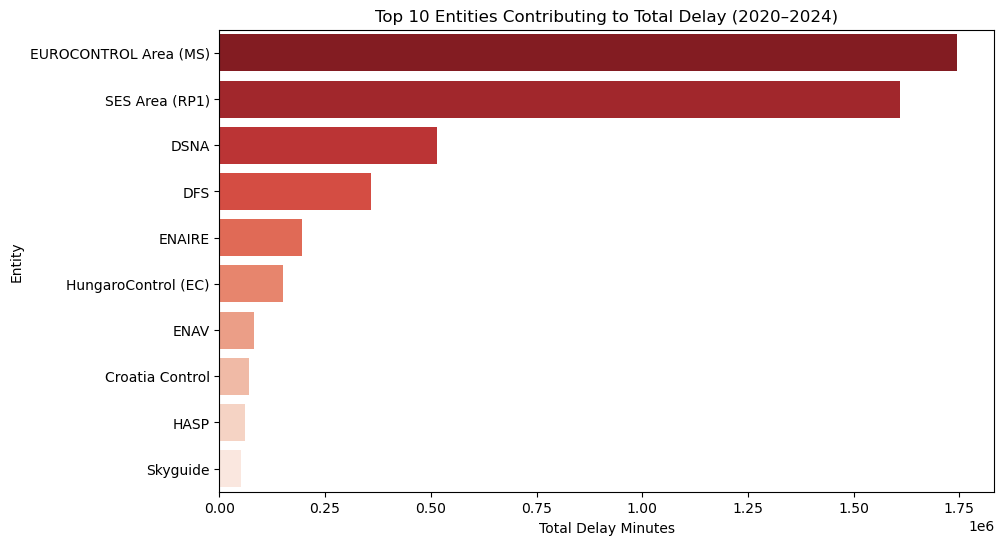

In [19]:
top_entities = df.groupby('ENTITY_NAME')['TOTAL_DELAY'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_entities.values, y=top_entities.index, palette='Reds_r')
plt.title('Top 10 Entities Contributing to Total Delay (2020–2024)')
plt.xlabel('Total Delay Minutes')
plt.ylabel('Entity')
plt.show()


 Train/Test Split

In [15]:
# last 6 months for testing
train = daily_delays.iloc[:-180]
test = daily_delays.iloc[-180:]

Time Series Forecasting (SARIMA)

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train['TOTAL_DELAY'],
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result = model.fit(disp=False)
forecast = result.forecast(steps=len(test))


 Plot Forecast vs Actual

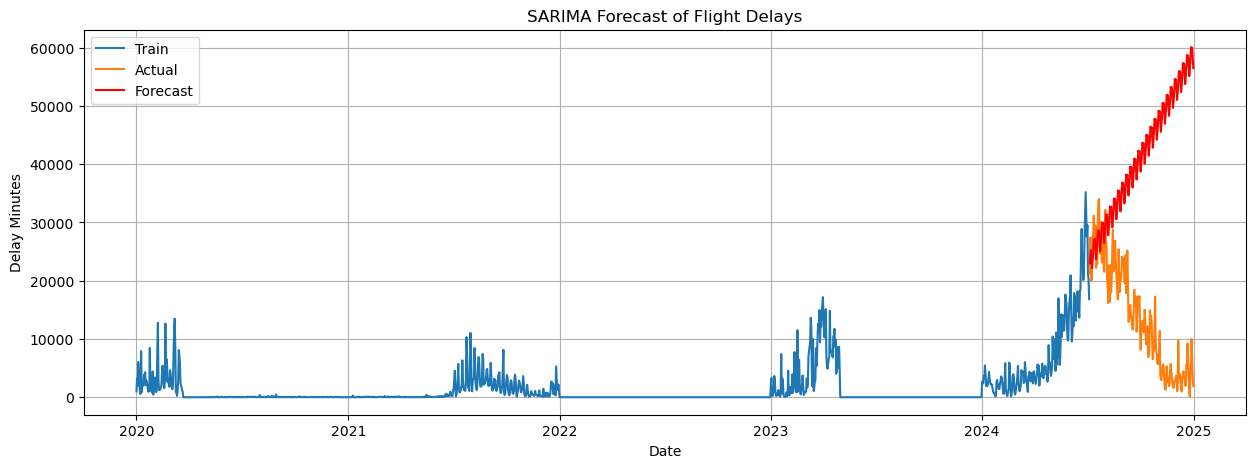

In [17]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['TOTAL_DELAY'], label='Train')
plt.plot(test.index, test['TOTAL_DELAY'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast of Flight Delays')
plt.xlabel('Date')
plt.ylabel('Delay Minutes')
plt.legend()
plt.grid(True)
plt.show()


Model Evaluation

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test['TOTAL_DELAY'], forecast)
rmse = np.sqrt(mean_squared_error(test['TOTAL_DELAY'], forecast))
print(f" MAE: {mae:,.2f} minutes")
print(f" RMSE: {rmse:,.2f} minutes")

 MAE: 28,270.87 minutes
 RMSE: 33,594.57 minutes


In [22]:
#Check relative error (MAPE or % error)
mape = (abs(test['TOTAL_DELAY'] - forecast) / test['TOTAL_DELAY']).mean() * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 917.67%


In [23]:
#Handle zeros in MAPE calculation
mask = test['TOTAL_DELAY'] != 0
mape = (abs(test['TOTAL_DELAY'][mask] - forecast[mask]) / test['TOTAL_DELAY'][mask]).mean() * 100
print(f"Adjusted MAPE (excluding zeros): {mape:.2f}%")


Adjusted MAPE (excluding zeros): 917.67%


Log transformation for stability

In [24]:
# Log transform
train_log = np.log1p(train['TOTAL_DELAY'])

model = SARIMAX(
    train_log,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)

# Forecast in log space, then invert
forecast_log = result.forecast(steps=len(test))
forecast = np.expm1(forecast_log)


In [25]:
mae = mean_absolute_error(test['TOTAL_DELAY'], forecast)
rmse = np.sqrt(mean_squared_error(test['TOTAL_DELAY'], forecast))

mask = test['TOTAL_DELAY'] != 0
mape = (abs(test['TOTAL_DELAY'][mask] - forecast[mask]) / test['TOTAL_DELAY'][mask]).mean() * 100

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


MAE: 255,612.67
RMSE: 378,867.10
Adjusted MAPE: 10071.42%


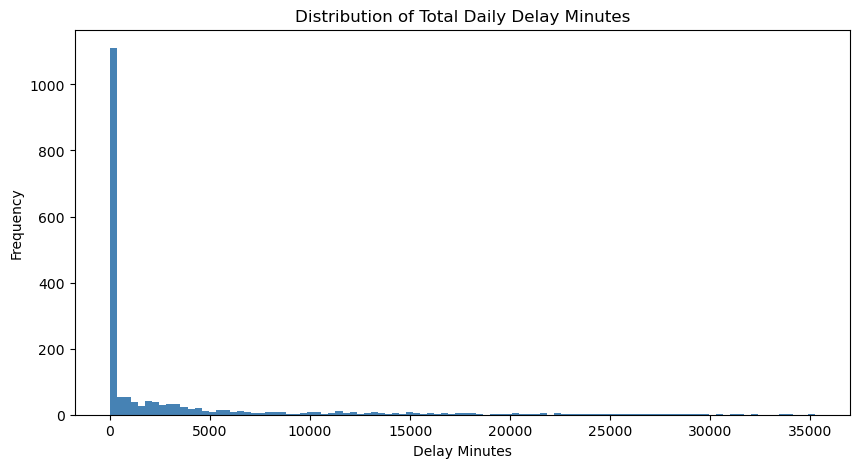

In [26]:
daily_delays['TOTAL_DELAY'].describe()
plt.figure(figsize=(10,5))
plt.hist(daily_delays['TOTAL_DELAY'], bins=100, color='steelblue')
plt.title('Distribution of Total Daily Delay Minutes')
plt.xlabel('Delay Minutes')
plt.ylabel('Frequency')
plt.show()


In [27]:
#Clip extreme outliers
cap = daily_delays['TOTAL_DELAY'].quantile(0.99)
daily_delays['TOTAL_DELAY_CLIPPED'] = daily_delays['TOTAL_DELAY'].clip(upper=cap)


In [28]:
#Re-run model on clipped data
train = daily_delays.iloc[:-180]
test = daily_delays.iloc[-180:]

train_log = np.log1p(train['TOTAL_DELAY_CLIPPED'])
model = SARIMAX(
    train_log,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)

forecast_log = result.forecast(steps=len(test))
forecast = np.expm1(forecast_log)

mae = mean_absolute_error(test['TOTAL_DELAY_CLIPPED'], forecast)
rmse = np.sqrt(mean_squared_error(test['TOTAL_DELAY_CLIPPED'], forecast))

mask = test['TOTAL_DELAY_CLIPPED'] != 0
mape = (abs(test['TOTAL_DELAY_CLIPPED'][mask] - forecast[mask]) / test['TOTAL_DELAY_CLIPPED'][mask]).mean() * 100

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"Adjusted MAPE: {mape:.2f}%")


MAE: 238,829.44
RMSE: 352,437.91
Adjusted MAPE: 9432.18%
